In [15]:
import torch
import torch.nn as nn
from torch import optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from datetime import datetime

from utils import FaceKeypointDataset, transform, train_test_split, train
from model.network import Net

In [16]:
# Load processed annotations
processed_annotations_csv = 'data/Annotations/processed_annotations.csv'
annotations_df = pd.read_csv(processed_annotations_csv)
processed_images_dir = 'data/Images_Processed'

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_dataset_samples(dataset, num_samples=5):
    """
    Visualizes a specified number of samples from the dataset with keypoints overlaid.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to visualize samples from.
        num_samples (int): Number of samples to visualize.
    """
    plt.figure(figsize=(15, 3 * num_samples))
    for i in range(num_samples):
        sample = dataset[i]
        if sample is None:
            continue
        image, keypoints = sample
        
        # If the image is a tensor, convert it to a numpy array
        if isinstance(image, torch.Tensor):
            image_np = image.numpy().transpose((1, 2, 0))
            # Unnormalize if the image was normalized during preprocessing
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_np = std * image_np + mean
            image_np = np.clip(image_np, 0, 1)
        elif isinstance(image, np.ndarray):
            image_np = image
        else:
            # Assume image is a PIL Image
            image_np = np.array(image)
        
        # Reshape keypoints to (num_keypoints, 2)
        keypoints = keypoints.numpy().reshape(-1, 2)
        
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(image_np)
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c='r', s=20, marker='x')
        plt.axis('off')
        plt.title(f"Sample {i+1}")
    
    plt.tight_layout()
    plt.show()


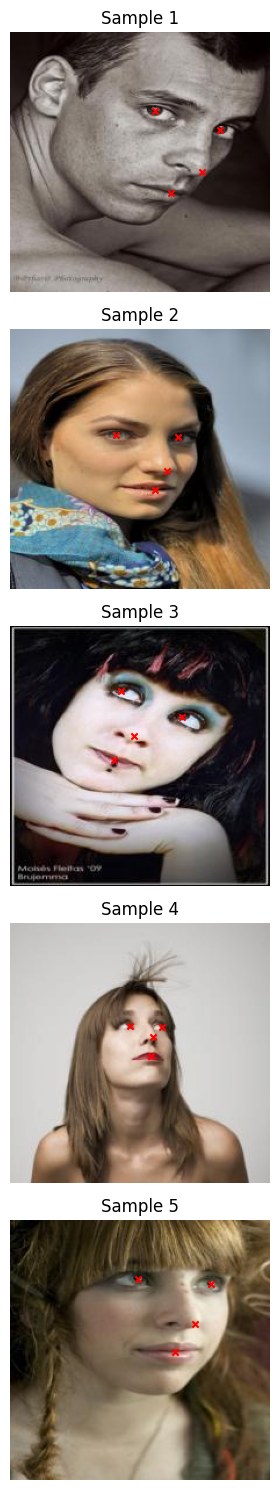

In [18]:
dataset = FaceKeypointDataset(annotations=annotations_df, 
                              root_dir=processed_images_dir, 
                              transform=transform)



# Visualize samples
visualize_dataset_samples(dataset, num_samples=5)

In [19]:
train_loader, val_loader, test_loader = train_test_split(dataset, 
                                                         train_size=0.8, 
                                                         val_size=0.1, 
                                                         batch_size=64)

In [20]:
# Initialize model
model = Net()

In [21]:
# Define loss function and optimizer
criterion_keypoints = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [22]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Start training
trained_model = train(model, 
                      criterion_keypoints, 
                      optimizer, 
                      scheduler, 
                      train_loader, 
                      val_loader, 
                      epochs=50, 
                      device=device, 
                      patience=10)  # Adjust patience as needed

Epoch 1/50 | Train Loss: 11258.9230 | Val Loss: 10695.9082
Validation loss decreased. Saving model...


Epoch 2/50 | Train Loss: 8652.6051 | Val Loss: 6202.2260
Validation loss decreased. Saving model...


Epoch 3/50 - Training:  53%|█████▎    | 86/162 [00:13<00:12,  6.04it/s, Batch Loss=3.08e+3]

In [13]:
def visualize_inference(model, dataset, device='cuda', num_samples=5):
    """
    Performs inference on a specified number of test samples and visualizes the predicted keypoints.

    Args:
        model (torch.nn.Module): Trained model.
        dataset (torch.utils.data.Dataset): The test dataset.
        device (str): Device to perform computations on ('cuda' or 'cpu').
        num_samples (int): Number of test samples to visualize.
    """
    model.to(device)
    model.eval()
    
    for i in range(num_samples):
        sample = dataset[i]
        if sample is None:
            continue
        image, true_landmarks = sample
        image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension

        with torch.no_grad():
            pred_keypoints = model(image_tensor)
        
        # Convert tensors to numpy arrays
        pred_keypoints = pred_keypoints.cpu().numpy().reshape(-1, 2)
        
        # Handle true_landmarks tensor
        if isinstance(true_landmarks, torch.Tensor):
            true_landmarks = true_landmarks.cpu().numpy()
        
        # Ensure true_landmarks is a 2D array
        if true_landmarks.ndim == 1:
            true_landmarks = true_landmarks.reshape(-1, 2)
        elif true_landmarks.ndim != 2 or true_landmarks.shape[1] != 2:
            raise ValueError(f"Unexpected shape for true_landmarks: {true_landmarks.shape}")
    
        # Handle image tensor
        if isinstance(image, torch.Tensor):
            image_np = image.cpu().numpy().transpose((1, 2, 0))
            # Unnormalize if the image was normalized during preprocessing
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_np = std * image_np + mean
            image_np = np.clip(image_np, 0, 1)
        elif isinstance(image, np.ndarray):
            image_np = image
        else:
            # Assume image is a PIL Image
            image_np = np.array(image)
        
        plt.figure(figsize=(6,6))
        plt.imshow(image_np)
        
        # Plot ground truth keypoints in green
        plt.scatter(true_landmarks[:, 0], true_landmarks[:, 1], c='g', s=20, label='Ground Truth')
        
        # Plot predicted keypoints in red
        plt.scatter(pred_keypoints[:, 0], pred_keypoints[:, 1], c='r', s=20, marker='x', label='Predicted')
        
        plt.title(f"Test Sample {i+1}")
        plt.axis('off')
        plt.legend()
        plt.show()

C:\Users\first\AppData\Local\Temp\ipykernel_31280\2646140651.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load('best_keypoint_mod

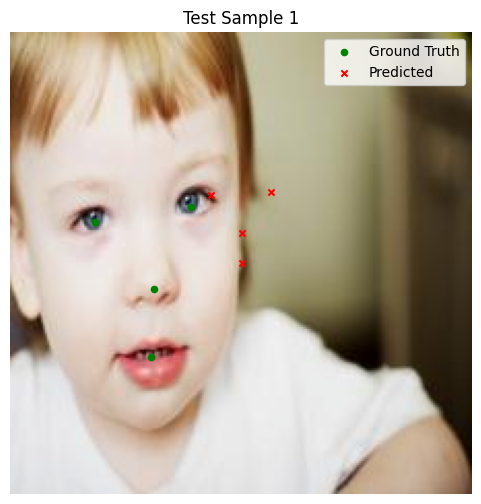

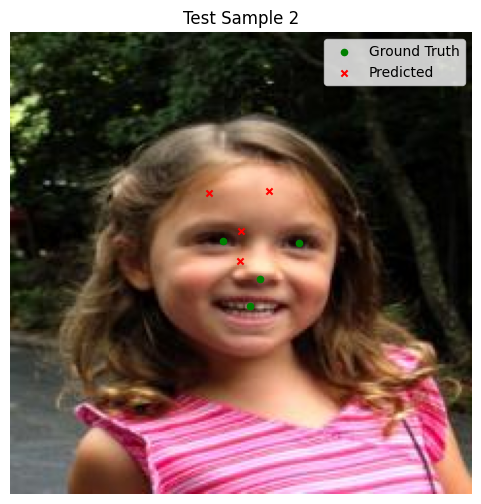

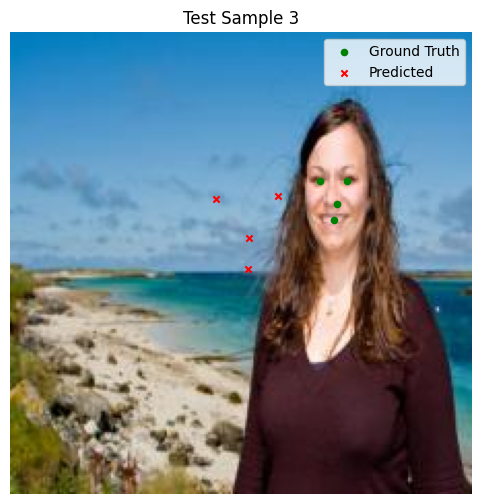

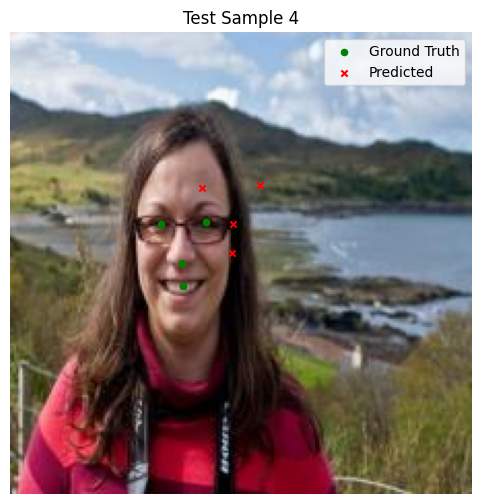

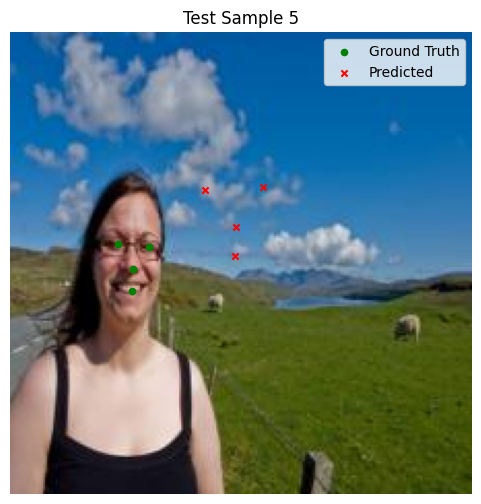

In [ ]:
test_df = annotations_df[int(len(annotations_df)*0.9):].reset_index(drop=True)
test_images_dir = processed_images_dir  # 'data/Images_Processed'

# Initialize test dataset
test_dataset = FaceKeypointDataset(annotations=test_df, 
                                   root_dir=test_images_dir, 
                                   transform=transform)  # 'transform' as defined in utils.py

# Initialize and load the trained model
trained_model = Net()
trained_model.load_state_dict(torch.load(f'best_keypoint_model.pth'))
trained_model.to(device)
trained_model.eval()

# Visualize inference on test samples
visualize_inference(trained_model, test_dataset, device=device, num_samples=5)

In [8]:
# torch.save(model.state_dict(), 'model_test_50_epochs_01142025.pth')

C:\Users\first\AppData\Local\Temp\ipykernel_14668\3755235618.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


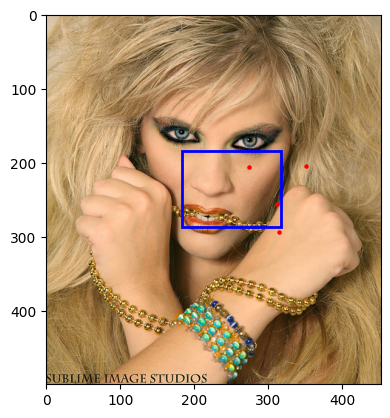

In [ ]:
# from PIL import Image
# import matplotlib.pyplot as plt

# test_image = r"data\Images\image00002.jpg"

# # Load the image
# image = Image.open(test_image)

# # Transform the image
# transformed_image = transform(image)

# # Add batch dimension
# transformed_image = transformed_image.unsqueeze(0)

# # Load the model
# model_path = 'model_test_23_epochs_01122025.pth'
# model = Net()
# model.load_state_dict(torch.load(model_path))
# model.to('cuda')
# model.eval()

# # Perform inference
# with torch.no_grad():
#     output = model(transformed_image.to('cuda'))

# # Process the output (assuming the model outputs keypoints and bbox)
# keypoints, bbox = output

# # Convert keypoints and bbox to numpy arrays
# keypoints = keypoints.cpu().numpy().reshape(-1, 2)
# bbox = bbox.cpu().numpy().flatten()

# # Plot the image and keypoints
# plt.imshow(image)
# plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='r')
# # Plot the bounding box
# rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, color='blue', linewidth=2)
# plt.gca().add_patch(rect)
# plt.show()